# Определение тональности (токсичности) текста

Нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

In [76]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import lightgbm as lgb
import catboost as cb

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import re
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

import spacy

In [2]:
#import nltk
#nltk.download()

In [59]:
try:
    data = pd.read_csv("g:/Projects/praktikum/datasets/toxic_comments.csv")
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Имеем корпус из 160к твитов.
* text - текст твита
* toxic - признак токсичности текста

# 1. Обработка данных

Предобработку данных будем осуществлять по следующей схеме (для каждой строки):
1. Токенизируем текст
2. Лемматизируем токены, используя Spacy
3. Удаляем из лемматизированного текста стоп-слова, используя Gensim.
4. Очищаем текст от лишних символов, за исключением букв английского алфавита и пробелов, c помощью Re.

In [56]:
# грузим английскую модель Spacy
nlp = spacy.load('en')

In [51]:
def clear_text(row):
    text = row['text']
    
    # токенизация
    tokens = nlp(text)
    lemm_result = []
    
    # лемматизация
    lemms_line = " ".join([token.lemma_ for token in tokens])
    
    # удаление стоп-слов
    text_no_sw = remove_stopwords(lemms_line)
    
    # очистка от мусора
    clear_lemms = re.sub(r'[^a-zA-Z]', ' ', text_no_sw)
    clear_text = " ".join(clear_lemms.split())
   
    return clear_text

In [61]:
notebook.tqdm.pandas()
data['clear_lemms'] = data.progress_apply(clear_text, axis=1)

G:\Anaconda\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [63]:
data.to_csv('toxic_c_clear2.csv', index=False)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         159571 non-null  object
 1   toxic        159571 non-null  int64 
 2   clear_lemms  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


Загрузим подготовленный файл, с очищенным текстом.

In [2]:
data=pd.read_csv('toxic_c_clear2.csv')

#некоторые твиты в исходных данных были некорректны, и в результате получили пустые строки с леммами - выбрасываем
data.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159518 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         159518 non-null  object
 1   toxic        159518 non-null  int64 
 2   clear_lemms  159518 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [4]:
data.head(2)['clear_lemms'].values

array(['explanation edit PRON username Hardcore Metallica Fan revert PRON vandalism closure gas PRON vote New York Dolls FAC remove template talk page PRON retire now',
       'd aww PRON match background colour PRON seemingly stick thank talk January UTC'],
      dtype=object)

Супер! Приступаем к подготовке к обучению!

## 2. Подготовка признаков (TF-IDF)

In [5]:
corpus = data['clear_lemms']
label = data['toxic']

Посмотрим на распределение целевого признака.

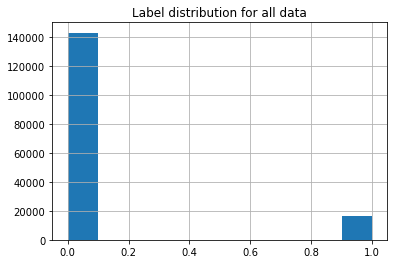

In [6]:
label.hist()
plt.title('Label distribution for all data')
plt.show()

Признак не сбалансирован - токсичных комментариев существенно меньше! Это станет проблемой - вместо обучения определять токсичные слова и словосочетания, модели будут забивать память ненужными данными из обычных комментов. <br/>
Лучшим решением здесь видится downsampling обучающей выборки, чтобы модели лучше опознали разницу между токсичными и обычными комментами.

Сначала отделим 0.2 комментариев на тестовую выборку.

In [53]:
corpus_train, corpus_test, label_train, label_test = train_test_split(corpus, label, test_size=0.2)
print('Train corpus:', corpus_train.shape)
print('Test corpus:', corpus_test.shape)

Train corpus: (127614,)
Test corpus: (31904,)


In [54]:
# функция принимает признаки и долю даунсемпла, уменьшает кол-во отрицательных признаков, перемешивает и возвращает балансированные признаки

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


In [55]:
# применим функцию к ТРЕНИРОВОЧНОЙ выборке, сократив количество отрицательных объектов в 6 раз
corpus_downsampled, label_downsampled = downsample(corpus_train, label_train, 0.13)

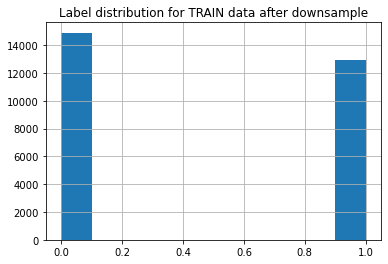

In [15]:
label_downsampled.hist()
plt.title('Label distribution for TRAIN data after downsample')
plt.show()

Уже лучше!

Теперь векторизируем признаки. <br/>
Используем алгоритм TF-IDF для получения векторов слов и их встречаемости в комментариях.

In [56]:
# инициализируем векторайзер и фитим на обучающей выборке
count_tfidf = TfidfVectorizer()
count_tfidf.fit(corpus_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [57]:
# трансформируем обучающий и тестовый корпуса
tf_idf_train = count_tfidf.transform(corpus_train)
tf_idf_test = count_tfidf.transform(corpus_test)

print('Train corpus', tf_idf_train.shape)
print('Label train', label_train.shape)
print('---')
print('Test corpus', tf_idf_test.shape)
print('Test label', label_test.shape)

Train corpus (127614, 138704)
Label train (127614,)
---
Test corpus (31904, 138704)
Test label (31904,)


Данные готовы к обучению моделей!

# 3. Обучение и тестирование моделей

In [58]:
# функция для теста. На вход - модель, на выходе метрики и ROC-график
def test_me(cur_model):    
    #probs and ROC-AUC
    probabilities_test = cur_model.predict_proba(tf_idf_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(label_test, probabilities_one_test)
    
    # F1 score
    predictions = cur_model.predict(tf_idf_test)
    f1 = f1_score(label_test, predictions)
    print('F1_Score=', f1)
    
    #график
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
            
    # AUC-ROC SCORE
    auc_roc = roc_auc_score(label_test, probabilities_one_test)
    print('ROC-AUC Score=', auc_roc)
    
    plt.show()
    return f1

In [59]:
result = pd.DataFrame(columns = ['F1_score'])

## 3.1 Logistic Regression

In [81]:
model_lr = LogisticRegression(random_state=112211,  class_weight='balanced')
model_lr.fit(tf_idf_train, label_train)

G:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=112211, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

F1_Score= 0.7470500474705005
ROC-AUC Score= 0.9715633691261596


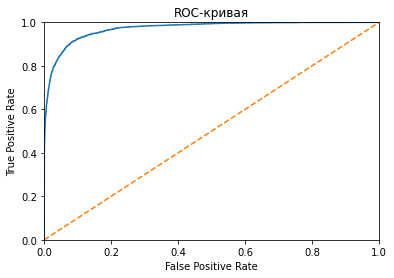

In [82]:
f1_lr = test_me(model_lr)

In [62]:
# собираем результаты тестов в табличку
result.loc['LogRegression'] = f1_lr
result

,F1_score
LogRegression,0.74705


## 3.2 RandomForestClassifier

In [35]:
# функция для обучения gridsearch
def RFC_grid(feat, targ):
    estimator = RandomForestClassifier(random_state=112211)
    param_grid = {
            "n_estimators"      : [500,1000],
            "max_features"      : ["auto"],
            "min_samples_leaf" : [1],
            "min_samples_split" : [10,20],
            "bootstrap": [False],
                }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, scoring='f1')
    rfr_grid.fit(feat, targ)

    print('...Search completed...')
    print('Best RMSE score', rfr_grid.best_score_)
    print('Best params:', rfr_grid.best_params_)

    return rfr_grid.best_params_

In [63]:
#RFC_params = RFC_grid(tf_idf_train, label_downsampled)
RFC_params = {'bootstrap': False, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 100, 'class_weight':'balanced'}

In [64]:
model_rfc = RandomForestClassifier(**RFC_params)
model_rfc.fit(tf_idf_train, label_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

F1_Score= 0.708930730696148
ROC-AUC Score= 0.9565920279726186


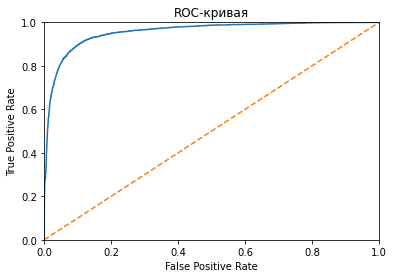

In [65]:
f1_rfc = test_me(model_rfc)

In [66]:
result.loc['RFClassifier'] = f1_rfc
result

,F1_score
LogRegression,0.747050
RFClassifier,0.708931


## 3.3 Linear Support Vector Classifier

In [78]:
model_svc = LinearSVC(tol=1e-5)
model_svc.fit(tf_idf_train, label_train)

predict = model_svc.predict(tf_idf_test)
f1_score(label_test, predict)

0.7810630661425396

In [68]:
result.loc['LinearSVC'] = f1_score(label_test, predict)
result

,F1_score
LogRegression,0.747050
RFClassifier,0.708931
LinearSVC,0.781063


## 3.4 AdaBoostClassifier

In [69]:
model_abc = AdaBoostClassifier(n_estimators=200, learning_rate=1)
model_abc.fit(tf_idf_train, label_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=200, random_state=None)

F1_Score= 0.7227191413237924
ROC-AUC Score= 0.942198574155529


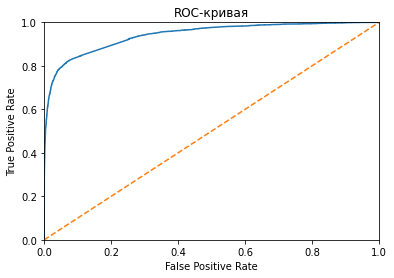

In [70]:
f1_ada = test_me(model_abc)

In [71]:
result.loc['AdaBoostClassifier'] = f1_ada
result

,F1_score
LogRegression,0.747050
RFClassifier,0.708931
LinearSVC,0.781063
AdaBoostClassifier,0.722719


## 3.5 LightGBM

In [89]:
lgb_params = {'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 1, 'num_leaves': 500, 'reg_lambda': 5}
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(tf_idf_train, label_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=5, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

F1_Score= 0.7661262504311832
ROC-AUC Score= 0.9640173246264488


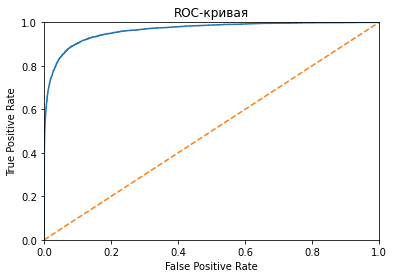

In [90]:
f1_lgb = test_me(model_lgb)

In [92]:
result.loc['LightGBM'] = f1_lgb
result

,F1_score
LogRegression,0.747050
RFClassifier,0.708931
LinearSVC,0.781063
AdaBoostClassifier,0.722719
LightGBM,0.766126


## 3.6 Catboost

In [95]:
cb_params = {'depth': 6, 'iterations': 1000, 'learning_rate': 0.4, 'verbose':100}
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(tf_idf_train, label_train)

0:	learn: 0.3858692	total: 974ms	remaining: 16m 12s
100:	learn: 0.1226014	total: 1m 16s	remaining: 11m 17s
200:	learn: 0.1053156	total: 2m 30s	remaining: 9m 57s
300:	learn: 0.0939667	total: 3m 45s	remaining: 8m 42s
400:	learn: 0.0871724	total: 4m 59s	remaining: 7m 27s
500:	learn: 0.0820333	total: 6m 13s	remaining: 6m 12s
600:	learn: 0.0774089	total: 7m 30s	remaining: 4m 58s
700:	learn: 0.0730345	total: 8m 44s	remaining: 3m 43s
800:	learn: 0.0690312	total: 9m 59s	remaining: 2m 28s
900:	learn: 0.0653819	total: 11m 13s	remaining: 1m 13s
999:	learn: 0.0616892	total: 12m 28s	remaining: 0us


F1_Score= 0.7759336099585061
ROC-AUC Score= 0.9646446212656845


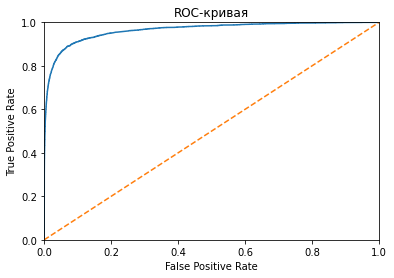

In [96]:
f1_cb = test_me(model_cb)

In [97]:
result.loc['CatBoost'] = f1_cb
result

,F1_score
LogRegression,0.747050
RFClassifier,0.708931
LinearSVC,0.781063
AdaBoostClassifier,0.722719
LightGBM,0.766126
CatBoost,0.775934
